# [프로젝트] 인물 모드 문제점 찾기
### Step 1. 인물모드 직접 해보기

- `최소 3장 이상 인물모드 사진(사람, 동물 가능)` !!!
- 배경 blur 인물모드 말고 배경사진을 다른 이미지로 교체하는 `크로마키 배경 합성 시도` !!!

### Step 2. 사진에서 문제점 찾기

- 인물 영역에 포함되어 상관없는 옷이 blur 되지 않고 나오는 경우
- 이상한 점 2개 더 찾기( `표시한 이미지 jupyter notebook에 포함해 제출` !!!)

### Step 3. 해결 방법을 제안해보기

- 인물모드 사진의 `문제점을 해결할 방안을 정리해 제안` !!!
    - DeepLab 모델의 Semantic Segmentation Mask 영역 적용의 문제점을 보완하는 솔루션
- 세그멘테이션의 한계
- 피사계 심도 이해하기
    - 아웃포커싱 하는 법
    - 얕은 피사계 심도 촬영의 이해
- 3D 카메라 활용하기
- 소프트웨어 기술 활용하기
- 다른 기술과 융합해보기

In [2]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

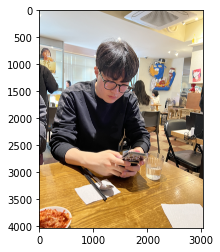

In [3]:
my_img_path = os.getenv('HOME')+'/aiffel/Aiffel_quest_rs/Exploration/Ex04/images/glassesmh.jpg'  
img_orig = cv2.imread(my_img_path)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 시맨틱 세그멘테이션 적용
DeepLab 세그멘테이션 모델 이용

In [4]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 

model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7dd3418ec190>)

In [5]:
# pixelLib 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(my_img_path)

### PASCAL VOC 데이터
PASCAL VOC 데이터로 학습된 모델 이용

In [6]:
# PASCAL 데이터의 Label 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

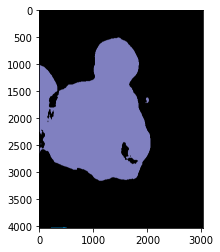

In [8]:
# semgentAspascalvoc() 함수 호출 -> 입력 이미지 분할 후 나온 결과값 시각화
rotated_output = cv2.rotate(output, cv2.ROTATE_90_CLOCKWISE)
plt.imshow(rotated_output)
plt.show()

In [9]:
# 입력 이미지 분할 후 결과 값 중 배열 값 출력
segvalues

{'class_ids': array([ 0, 11, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [10]:
# class_ids에 담겨있는 값을 pascalvoc 담겨있는 라벨 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
diningtable
person


In [11]:
# pixelLib 컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [12]:
# zjffjapq 15 배열 출력. 이처럼 다른 물체들을 찾는데 사용
colormap[15]

array([192, 128, 128])

(4032, 3024)


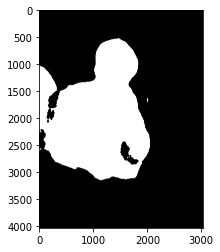

In [13]:
# BGR 순서로 채널 배치가 되어 있기에 RGB 순으로 돌림
seg_color = (128,128,192)

# 출력값 픽셀별 색상=seg_color -> 1(True) , 픽셀별 색상!=seg_color -> 0(False)
# seg_color 값은 사람을 나타냄. 사람 위치 제외 gray로 출력해야함
seg_map = np.all(rotated_output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

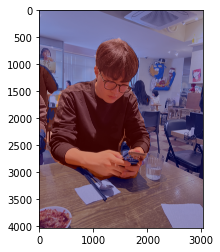

In [14]:
# 원래 이미지와 겹쳐 세그멘테이션 확인
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 흐리게 하기

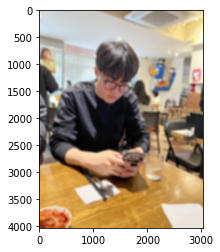

In [19]:
# `blur()` 함수 사용해 배경 흐리게 하기
img_orig_blur = cv2.blur(img_orig, (50,50)) # 해상도가 높아서 그런지 블러가 잘 안되서 50 높이기
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

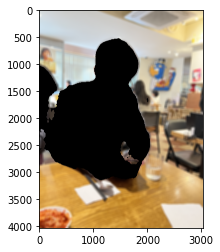

In [20]:
# 원본(BGR) -> 이미지 색상 채널(RGB) 변경
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 배경 0, 사람 255 -> 배경 255, 사람 0
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and(): 배경만 있는 영상 얻기 => 사람이 사라지고 배경만 남음
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐린 배경과 원본 영상 합성

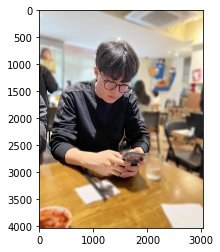

In [21]:
# np.where() 로 세그멘테이션 마스크 255부분만 원본 이미지 값을 가져옴. 아닌 영역은 블러된 이미지
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

# cv2.COLOR_BGR2RGB: BGR 형식 -> RGB 형식으로 변경
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### 사람->블러, 배경->원본 해보기

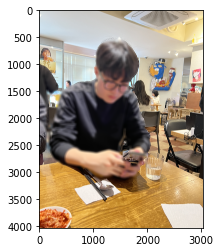

In [22]:
img_concat = np.where(img_mask_color == 255, img_orig_blur, img_orig)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 배경전환 크로마키 사진
### 절차
1. 세그멘테이션 마스크를 사용해 사람 영역과 배경 영역을 분리.
2. 배경 이미지를 준비하고, 원본 이미지와 크기가 같도록 맞추기.
3. 사람 영역은 원본 이미지에서 유지하고, 배경 영역은 새로운 이미지로 대체.

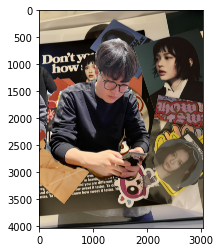

In [24]:
# img_background 는 크로마키
back_img_path = os.getenv('HOME')+'/aiffel/Aiffel_quest_rs/Exploration/Ex04/images/hannie_cd.JPG'  
img_background = cv2.imread(back_img_path)

img_background_resized = cv2.resize(img_background, (img_orig.shape[1], img_orig.shape[0]))

# np.where를 사용하여 사람 부분은 원본 이미지, 배경 부분은 새로운 배경 이미지로 교체
img_concat = np.where(img_mask_color == 255, img_orig, img_background_resized)

# 이미지를 시각화
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 동물 사진 인물 모드
동물원에 갔을 때 찍은 호랑이를 아웃포커싱 해보겠다.

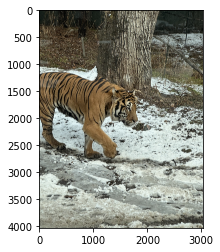

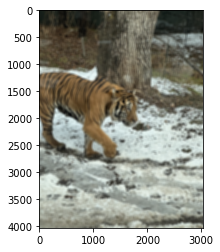

error: OpenCV(4.5.3) /tmp/pip-req-build-agffqapq/opencv/modules/core/src/arithm.cpp:212: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'binary_op'


In [27]:
# 이미지 및 모델 경로 설정
image_path = os.getenv('HOME') + '/aiffel/Aiffel_quest_rs/Exploration/Ex04/images/tiger.jpg'
model_dir = os.getenv('HOME') + '/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# 모델 다운로드
if not os.path.exists(model_file):
    model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
    urllib.request.urlretrieve(model_url, model_file)

# 원본 이미지 로드
img_original = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
plt.show()

# PixelLib 세그멘테이션 모델 로드 및 실행
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 이미지 세그멘테이션 수행
segmentation_result, segmentation_output = model.segmentAsPascalvoc(image_path)

# 사람을 나타내는 픽셀을 추출 (PASCAL VOC에서 사람 class_id = 15)
tiger_class_id = 8
tiger_mask = (segmentation_output == tiger_class_id).all(axis=-1)

# 마스크를 255로 변환하여 이진 마스크 생성
img_tiger_mask = tiger_mask.astype(np.uint8) * 255

# 배경 흐림 처리
img_blur_background = cv2.blur(img_original, (50, 50))
plt.imshow(cv2.cvtColor(img_blur_background, cv2.COLOR_BGR2RGB))
plt.show()

# 이진 마스크를 BGR 형식으로 변환
img_tiger_mask_color = cv2.cvtColor(img_tiger_mask, cv2.COLOR_GRAY2BGR)

# 배경만 남기는 마스크 생성 (cv2.bitwise_not()으로 반전)
img_background_mask = cv2.bitwise_not(img_tiger_mask_color)
plt.imshow(cv2.cvtColor(img_background_mask, cv2.COLOR_BGR2RGB))
plt.show()

# 배경만 흐리게 처리된 이미지 생성
img_only_blur_bg = cv2.bitwise_and(img_blur_background, img_background_mask)
plt.imshow(cv2.cvtColor(img_only_blur_bg, cv2.COLOR_BGR2RGB))

# 사람 영역은 원본 이미지를 사용하고, 배경은 블러된 이미지를 사용하는 최종 합성
img_final_result = np.where(img_person_mask_color == 255, img_original, img_only_blur_bg)

# 최종 결과 시각화
plt.imshow(cv2.cvtColor(img_final_result, cv2.COLOR_BGR2RGB))
plt.show()


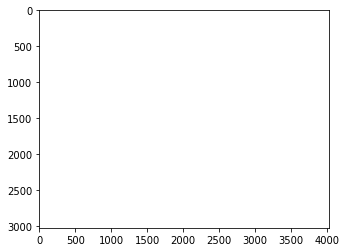

In [28]:
img_background_mask = cv2.bitwise_not(img_tiger_mask_color)
plt.imshow(cv2.cvtColor(img_background_mask, cv2.COLOR_BGR2RGB))
plt.show()da